# EvolveGCN: Evolving Graph Convolutional Networks for Dynamic Graphs

什么是节点嵌入？

把原本图中某个节点的结构、属性信息，转换成一个低维向量表示，用来作为机器学习模型的输入。

| 概念          | 传统GNN              | EvolveGCN 的创新             |
| ----------- | ------------------ | ------------------------- |
| GCN 是否有时序能力 |  没有               |  用 RNN 给参数加时间演化能力        |
| 节点嵌入        | 静态表示或用RNN更新        | 不显式维护节点序列嵌入，而用随时间演化的GCN计算 |
| 时间建模方式      | 通常用 RNN/GAT 处理嵌入序列 | 用 RNN 直接建模 GCN 的参数变化      |


现有动态图方法通常依赖节点嵌入并用 RNN 建模时间变化，但它们需要完整的时间信息，难以应对节点集合频繁变化的场景。

**EvolveGCN** 通过使用 RNN 演化 GCN 的参数，在时间维度上建模图的动态演化，**无需维护节点嵌入**，更适用于节点变化剧烈的动态图。应用于链路预测、边分类、节点分类。


本文GCN 的参数不再直接训练，而是由 RNN 计算得出。使用 RNN 来更新 GCN 模型参数，而不是节点嵌入，即在每个时间步对模型结构本身进行自适应调整。

模型关注的是 GCN 自身参数，而不是依赖于特定的节点，所以不受节点变化影响。参数规模不会随着时间步数量增加。

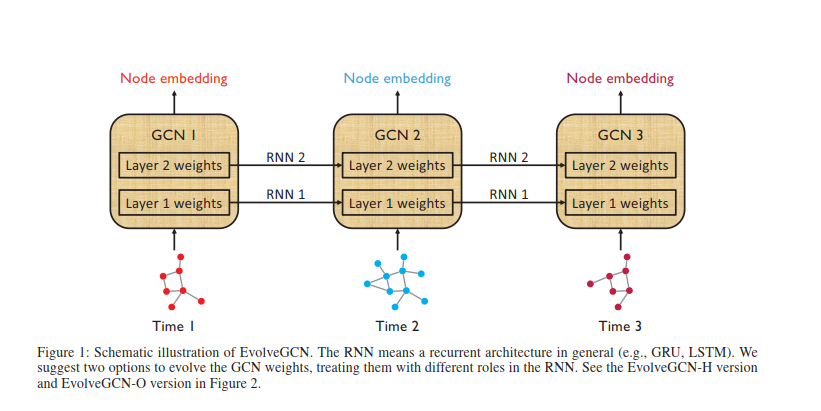


使用GCN得到节点的嵌入， 从上一个时间到下一个时间使用RNN去计算GCN层的参数

### EvolveGCN-H（"H" for Hidden state）

* 把 GCN 的参数 $W_t^{(l)}$ 视为 **RNN 的隐藏状态（hidden state）**。
* 使用 GRU 的形式：GRU 的输入是上一时间的节点嵌入 $H_t^{(l)}$，输出是新的 GCN 权重。
* 总体流程：

  $ W_t^{(l)} = GRU(H_t^{(l)}, W_{t-1}^{(l)}) $
  
  $ H_{t}^{(l+1)} = GCONV(A_t, H_t^{(l)}, W_t^{(l)}) $


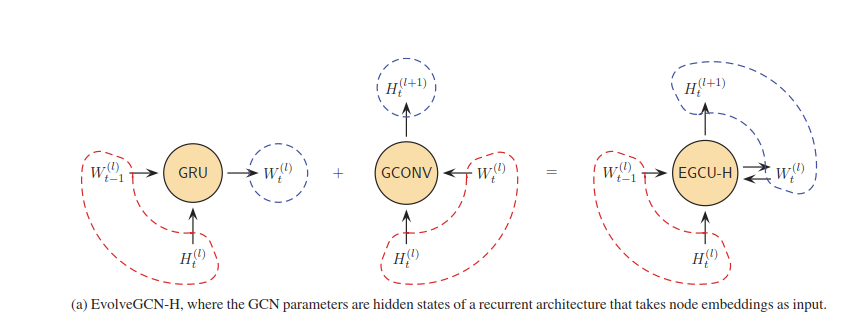


### EvolveGCN-O（"O" for Output）

* 把 GCN 的参数 $W_t^{(l)}$ 视为 **RNN 的输出（output）**。
* 使用 LSTM，直接将上一时间的权重作为输入：

  
  $ W_t^{(l)} = LSTM(W_{t-1}^{(l)}) $
  
  $ H_{t}^{(l+1)} = GCONV(A_t, H_t^{(l)}, W_t^{(l)}) $
  
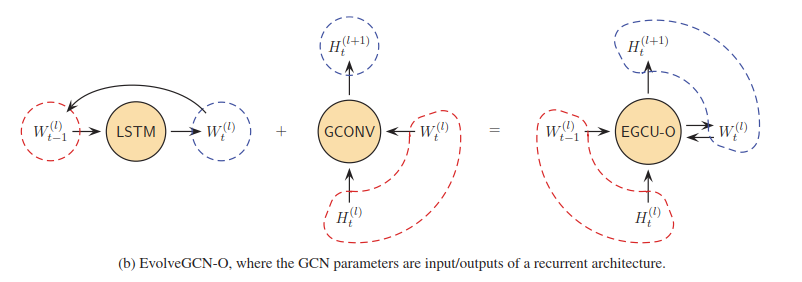




## 对比：

| 特征     | EGCU-H (GRU)               | EGCU-O (LSTM)   |
| ------ | -------------------------- | --------------- |
| 输入     | $H_t^{(l)}, W_{t-1}^{(l)}$ | $W_{t-1}^{(l)}$ |
| 权重更新方式 | 感知节点特征，按需调整                | 自我演化，不依赖图数据     |
| 灵活性    | 更强，适应性好                    | 更简单，泛化性差        |
| 难度     | 稍高（需处理嵌入）                  | 简单实现            |



## EGCU-H（GRU-based）详细实现

用 **GRU 演化 GCN 的权重矩阵**， 输入包含当前节点嵌入 $H_t^{(l)}$ 和前一时间步的权重 $W_{t-1}^{(l)}$，实现挑战：**GRU 原本处理向量**，这里要扩展为处理 **矩阵（即多个列向量）**


 GRU 单元:
 输入：
  * $X_t \in \mathbb{R}^{d \times k}$：输入矩阵
  * $H_{t-1} \in \mathbb{R}^{d \times k}$：隐藏状态矩阵 = 上一时刻的 GCN 权重
 输出：
  * Ht：新的 GCN 权重矩阵

算法：

```plaintext
1: function Ht = g(Xt, Ht−1)
2:     Zt = sigmoid(WZ * Xt + UZ * Ht−1 + BZ)
3:     Rt = sigmoid(WR * Xt + UR * Ht−1 + BR)
4:     Ĥt = tanh(WH * Xt + UH * (Rt ∘ Ht−1) + BH)
5:     Ht = (1 − Zt) ∘ Ht−1 + Zt ∘ Ĥt
6: end function
```

更新门Zt，决定当前时间从旧状态中保留多少信息。

```plaintext
Zt = sigmoid(WZ * Xt + UZ * Ht−1 + BZ)
```

* 参数：

  * `WZ`：输入 Xt 的线性变换参数
  * `UZ`：隐藏状态 Ht−1 的线性变换参数
  * `BZ`：偏置项
* `sigmoid` 输出值在 \[0, 1]，控制信息融合的权重


重置门，控制过去信息“忘记”的程度，计算Ĥt 时候遗忘成都

```plaintext
Rt = sigmoid(WR * Xt + UR * Ht−1 + BR)
```
候选状态 Ĥt 

```plaintext
Ĥt = tanh(WH * Xt + UH * (Rt ∘ Ht−1) + BH)
```

当前输入 `Xt` 和 **被重置门调整后的旧状态 `Rt ∘ Ht−1`**，  `∘` 是 **Hadamard 乘积**（按元素相乘）

最终输出状态更新 Ht

```plaintext
Ht = (1 − Zt) ∘ Ht−1 + Zt ∘ Ĥt
```

 **更新门 `Zt`** 控制：

  * 保留多少旧状态 $H_{t-1}$
  * 采用多少新状态 $\hat{H}_t$


### GRU 的输入（summarized node embeddings）和隐藏状态（GCN 权重矩阵）需要**在列数维度上对齐**。

GRU 的输入和隐藏状态维度必须一致（比如都是 $d \times k$），但，节点嵌入 $H_t^{(l)} \in \mathbb{R}^{n \times d}$，通常是 **n 个节点**， GCN 权重矩阵 $W_t^{(l)} \in \mathbb{R}^{d \times k}$，列数是 **k 个特征通道**

这个时候节点嵌入以及权重矩阵得维度不对需要缩减n->d

于是引入了**Summarize 函数**将原始的节点表示矩阵 压缩成 **k 个代表性的“伪节点”向量**

伪代码：

```plaintext
1: function Zt = summarize(Xt, k)
2:     yt = Xt * p / ||p||          # 每一行节点的“重要性分数”
3:     it = top-indices(yt, k)      # 选择前 k 个分数对应的行索引
4:     Zt = [Xt ∘ tanh(yt)]_it      # 选中的行做加权生成输出矩阵
5: end function
```

`Xt`: 输入节点嵌入矩阵，大小为 $n \times d$
`k`: 希望提取的代表节点数
`Zt`: 输出是 $k \times d$ 或 $d \times k$，作为 GRU 的输入

```plaintext
yt = Xt * p / ||p||
```

$ p ∈ \mathbb{R}^d $ 是一个 learnable 向量参数，与时间无关 然后对每个节点的嵌入进行 投影得分，每个节点的得分 𝑦𝑖 表示该节点嵌入在 p 方向上的投影长度，归一化后表示“与 p 的对齐程度”。

得到得分然后tanh映射到-1，1，然后加权， 求出结果，然后取出最大的k个赋值给Zt



#### GRU 更新（核心）

$ text
W_t^{(l)} = GRU(H_t^{(l)}, W_{t-1}^{(l)}) 
         := g(summarize(H_t^{(l)}, k)^T, W_{t-1}^{(l)})
$


## EGCU-O（LSTM-based）详细实现

**GCN 权重矩阵自己作为 LSTM 的输入和输出**, 不使用当前的节点嵌入 $H_t^{(l)}$，只看权重的时间演化

$
W_t^{(l)} = LSTM(W_{t-1}^{(l)}) := f(W_{t-1}^{(l)})
$



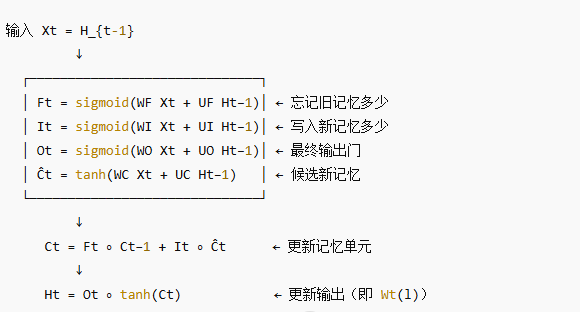




















EGCU-H 更适合的情况：图的结构变化较弱 ,需要让 GCN 权重感知节点特征

EGCU-O 更适合的情况：节点特征噪声大、不稳定,图结构变化频繁,更关心结构的时序演化

 对比总结表

| 特征               | EGCU-H（GRU） | EGCU-O（LSTM） |
| ---------------- | ----------- | ------------ |
| 是否用节点嵌入作为 RNN 输入 |  是         |  否          |
| 结构复杂度            | 较高          | 较低           |
| 感知图特征变化          |  强         |  弱          |
| 适用于              | 节点特征丰富场景    | 图结构主导场景      |
| 示例               | 社交图、交通图     | 通信图、设备间连接    |



In [ ]:
# 官方代码


class Sp_GCN_LSTM_A(Sp_GCN):
    def __init__(self,args,activation):
        super().__init__(args,activation)
        self.rnn = nn.LSTM(
                input_size=args.layer_2_feats,
                hidden_size=args.lstm_l2_feats,
                num_layers=args.lstm_l2_layers
                )

    def forward(self,A_list, Nodes_list = None, nodes_mask_list = None):
        last_l_seq=[]
        for t,Ahat in enumerate(A_list):
            node_feats = Nodes_list[t]
            #A_list: T, each element sparse tensor
            #note(bwheatman, tfk): change order of matrix multiply
            last_l = self.activation(Ahat.matmul(node_feats.matmul(self.w_list[0])))
            for i in range(1, self.num_layers):
                last_l = self.activation(Ahat.matmul(last_l.matmul(self.w_list[i])))
            last_l_seq.append(last_l)

        last_l_seq = torch.stack(last_l_seq)

        out, _ = self.rnn(last_l_seq, None)
        return out[-1]


class Sp_GCN_GRU_A(Sp_GCN_LSTM_A):
    def __init__(self,args,activation):
        super().__init__(args,activation)
        self.rnn = nn.GRU(
                input_size=args.layer_2_feats,
                hidden_size=args.lstm_l2_feats,
                num_layers=args.lstm_l2_layers
                )

class Sp_GCN_LSTM_B(Sp_GCN):
    def __init__(self,args,activation):
        super().__init__(args,activation)
        assert args.num_layers == 2, 'GCN-LSTM and GCN-GRU requires 2 conv layers.'
        self.rnn_l1 = nn.LSTM(
                input_size=args.layer_1_feats,
                hidden_size=args.lstm_l1_feats,
                num_layers=args.lstm_l1_layers
                )

        self.rnn_l2 = nn.LSTM(
                input_size=args.layer_2_feats,
                hidden_size=args.lstm_l2_feats,
                num_layers=args.lstm_l2_layers
                )
        self.W2 = Parameter(torch.Tensor(args.lstm_l1_feats, args.layer_2_feats))
        u.reset_param(self.W2)

    def forward(self,A_list, Nodes_list = None, nodes_mask_list = None):
        l1_seq=[]
        l2_seq=[]
        for t,Ahat in enumerate(A_list):
            node_feats = Nodes_list[t]
            l1 = self.activation(Ahat.matmul(node_feats.matmul(self.w_list[0])))
            l1_seq.append(l1)

        l1_seq = torch.stack(l1_seq)

        out_l1, _ = self.rnn_l1(l1_seq, None)

        for i in range(len(A_list)):
            Ahat = A_list[i]
            out_t_l1 = out_l1[i]
            #A_list: T, each element sparse tensor
            l2 = self.activation(Ahat.matmul(out_t_l1).matmul(self.w_list[1]))
            l2_seq.append(l2)

        l2_seq = torch.stack(l2_seq)

        out, _ = self.rnn_l2(l2_seq, None)
        return out[-1]


class Sp_GCN_GRU_B(Sp_GCN_LSTM_B):
    def __init__(self,args,activation):
        super().__init__(args,activation)
        self.rnn_l1 = nn.GRU(
                input_size=args.layer_1_feats,
                hidden_size=args.lstm_l1_feats,
                num_layers=args.lstm_l1_layers
               )

        self.rnn_l2 = nn.GRU(
                input_size=args.layer_2_feats,
                hidden_size=args.lstm_l2_feats,
                num_layers=args.lstm_l2_layers
                )